# **Avaliação 3** — Introdução ao Aprendizado de Máquina (ENGG67)
---

### **Docente:**
Antônio C. L. Fernandes Jr.

### **Discentes:**
- Beatriz Pereira Espinheira  
- Djair Maykon de Novaes Miranda

---

## **Questão1**


Escolha uma tarefa de classificação ou regressão que possa ser abordada utilizando MLPs. Selecione um banco de dados adequado (sugestões em https://archive.ics.uci.edu/).
Projete e treine uma **rede MLP de duas camadas** para resolver a tarefa pretendida. Utilize o **método de validação cruzada k-fold** para avaliar o treinamento do modelo.

---

# **Rede Neural de Classificação** - Pima Indians diabetes

## **Sobre o dataset**

O dataset **Pima Indians Diabets**
https://pmc.ncbi.nlm.nih.gov/articles/PMC8943493/
é um conjunto de dados disponibilizado pelo National Institute of Diabetes and Digestive and Kidney Diseases (NIDDK) com a finalidade de prever diagnosticamente o início da diabetes. <br/>
Os dados contém dados médicos de pacientes mulheres com pelo menos 21 anos de idade e de herança Pima Indian.<br/>
A escolha do dataset Pima Indians Diabetes foi feita porque queriamos trabalhar com um problema de **classificação binária**, mas que não fosse linearmente separável ou mais simples como o dataset Iris, por exemplo. <br/>
Esse conjunto de dados é um pouco mais desafiador, já que ao analisar visualizações como histogramas, boxplots e scatterplots, é possível perceber uma grande sobreposição entre as classes e suas distribuições. Por isso, faz sentido o uso de uma rede neural MLP (Perceptron Multicamadas), que é capaz de aprender padrões mais complexos e não lineares entre as variáveis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [ ]:
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"

try:
    df = pd.read_csv(url)
except Exception as e:
  print(e)

O conjunto de dados é composto por 768 instâncias e um total de 9 atributos.
Esse Dataset se trata de um problema de classificação binária com o objetivo de prever se uma paciente desenvolverá diabetes (classe 1) ou não (classe 0) dentro de cinco anos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


É possível perceber que o dataset não tem valores nulos, e todos os seus atributos são numéricos, alguns racionais e outros inteiros.

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


O conjunto de dados inclui 8 atributos preditores e 1 atributo alvo. <br/>

**Atributos Preditivos:**

*  **Pregnancies:** Número de vezes que a paciente esteve grávida.
*  **Glucose:** Concentração de glicose no plasma 2 horas após um teste de tolerância à glicose oral.
*  **BloodPressure:** Pressão arterial diastólica $(mm Hg)$.
*  **SkinThickness:** Espessura da dobra cutânea do tríceps $(mm)$.
*  **Insulin:** Nível de insulina sérica de 2 horas $(mu U/ml)$.
*  **BMI:** Índice de Massa Corporal $(peso em kg\div(altura em m)^2)$.
*  **DiabetesPedigreeFunction:** Função de Pedigree de Diabetes (uma pontuação de predisposição genética).
*  **Age:** Idade (anos).

**Atributo Alvo:**

* **Outcome :** Variável que representa a classe da instância (0 para não diabética, 1 para sim)

---
## **Análise Exploratória dos Dados (EDA)**

In [ ]:
df['Outcome'].value_counts(normalize=True)*100

,proportion
Outcome,
0,65.104167
1,34.895833


Podemos ver que existe um **desbalanceamento** entre classes com apenas ãproximadamente 35% sendo pacientes com diabetes (output 1).
Diante desse fato é necessário estudar se existe necessidade de um balanceamento visto que, visto que a classe minoritária pode ser prejudicada, mas essa distribuição também pode refletir as proporções reais encontradas nessa população, portanto uma analise mais criteriosa tem de ser feita.

In [ ]:
X = df.drop(columns='Outcome').values
y = df['Outcome'].values

estatisticas=[]
colunas = df.columns

for coluna in range(X.shape[1]):
    dados = X[:, coluna]

    estatisticas.append({
        'Atributo ':colunas[coluna],
        'Frequência (não-nulos)': len(dados),
        'Média': np.mean(dados),
        'Mediana': np.median(dados),
        'Desvio-Padrão': np.std(dados, ddof=1),
        'Q1': np.quantile(dados, 0.25),
        'Q3': np.quantile(dados, 0.75),
        'Obliquidade (Skew)': skew(dados),
        'Curtose (Kurtosis)': kurtosis(dados)
    })

estatisticas_df = pd.DataFrame(estatisticas)
estatisticas_df


,Atributo,Frequência (não-nulos),Média,Mediana,Desvio-Padrão,Q1,Q3,Obliquidade (Skew),Curtose (Kurtosis)
0,Pregnancies,768,3.845052,3.0000,3.369578,1.00000,6.00000,0.899912,0.150383
1,Glucose,768,120.894531,117.0000,31.972618,99.00000,140.25000,0.173414,0.628813
2,BloodPressure,768,69.105469,72.0000,19.355807,62.00000,80.00000,-1.840005,5.138691
3,SkinThickness,768,20.536458,23.0000,15.952218,0.00000,32.00000,0.109159,-0.524494
4,Insulin,768,79.799479,30.5000,115.244002,0.00000,127.25000,2.267810,7.159575
5,BMI,768,31.992578,32.0000,7.884160,27.30000,36.60000,-0.428143,3.261257
6,DiabetesPedigreeFunction,768,0.471876,0.3725,0.331329,0.24375,0.62625,1.916159,5.550792
7,Age,768,33.240885,29.0000,11.760232,24.00000,41.00000,1.127389,0.631177


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


É possivel perceber que existem atributos em escalas muito diferentes o que indica a **necessidade de normalização dos dados** ex: Insulina varia de 0 até 196 e
Pregnancies de 0 até 17. <br/>
Além disso **é possível notar algumas inconsistências nos dados:** Ao fazer algumas pesquisas conseguimos notar que valores 0 para os atributos Glicose, Pressão Sanguínea, Grossura da dobra de pele, Insulina, IMC, são impossíveis logo indicando a presença de dados faltantes ou ruído nos dados.

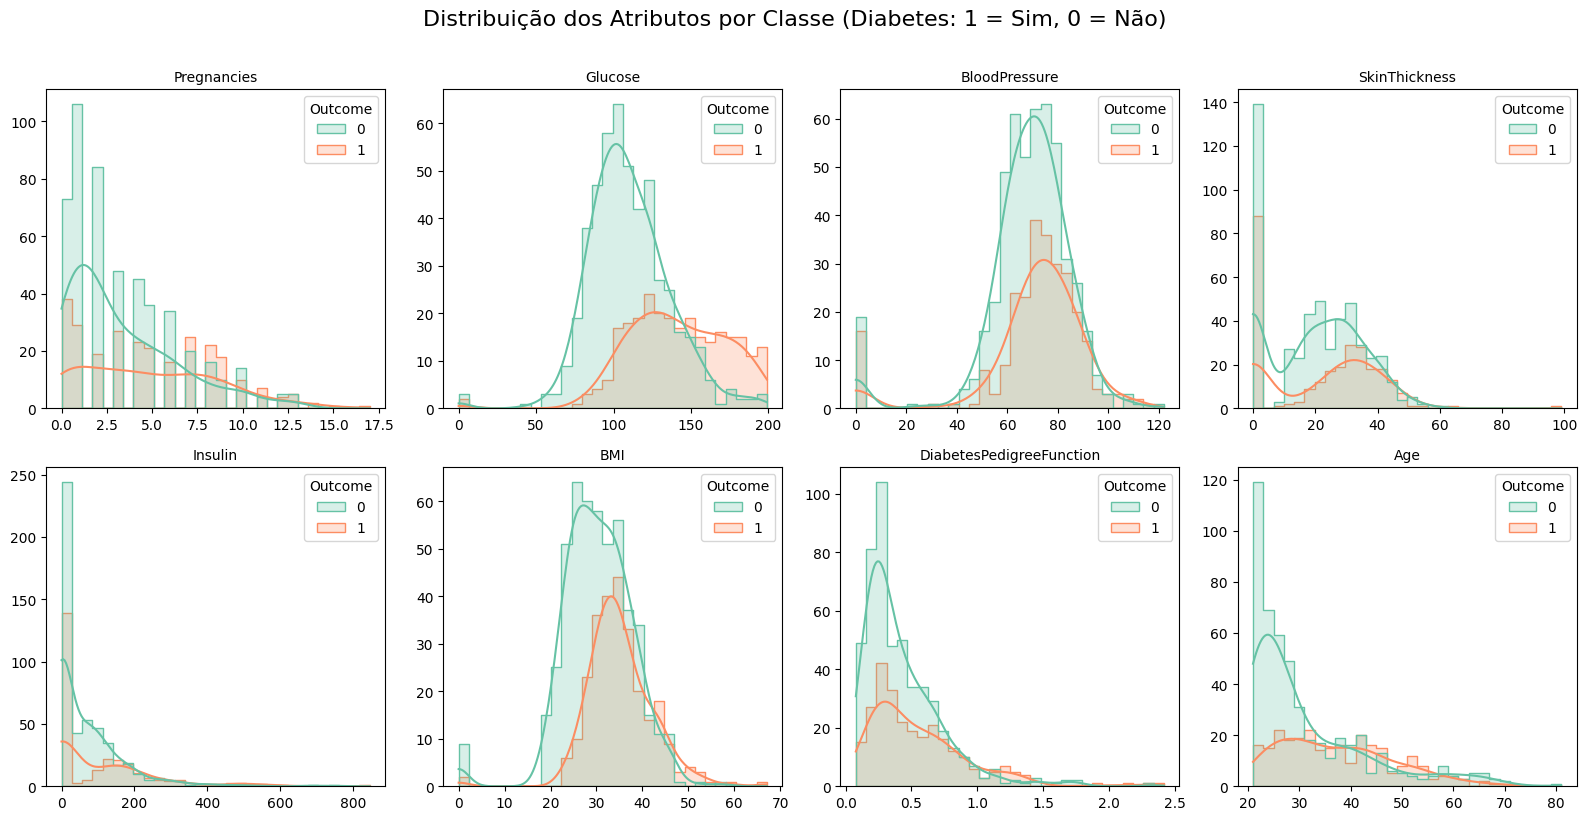

In [ ]:
target_col = 'Outcome'
features = df[[col for col in df.columns if col != target_col]]

n_cols = 4
n_rows = (len(features.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features.columns):
    sns.histplot(
        data=df,
        x=feature,
        hue=target_col,
        bins=30,
        element='step',
        palette='Set2',
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(feature, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.suptitle('Distribuição dos Atributos por Classe (Diabetes: 1 = Sim, 0 = Não)', fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

A partir dos histogramas é possível perceber uma leve assimetria nas distribuições, com diferentes graus a depender dos atributos:
* **Assimetria positiva (à direita):** Pregnancies, DiabetesPedigreeFunction, SkinThickness, Age.
* **Assimetria negativa (à esquerda):** BloodPressure.
* **Menos assimétricas:** Glucose, BMI.

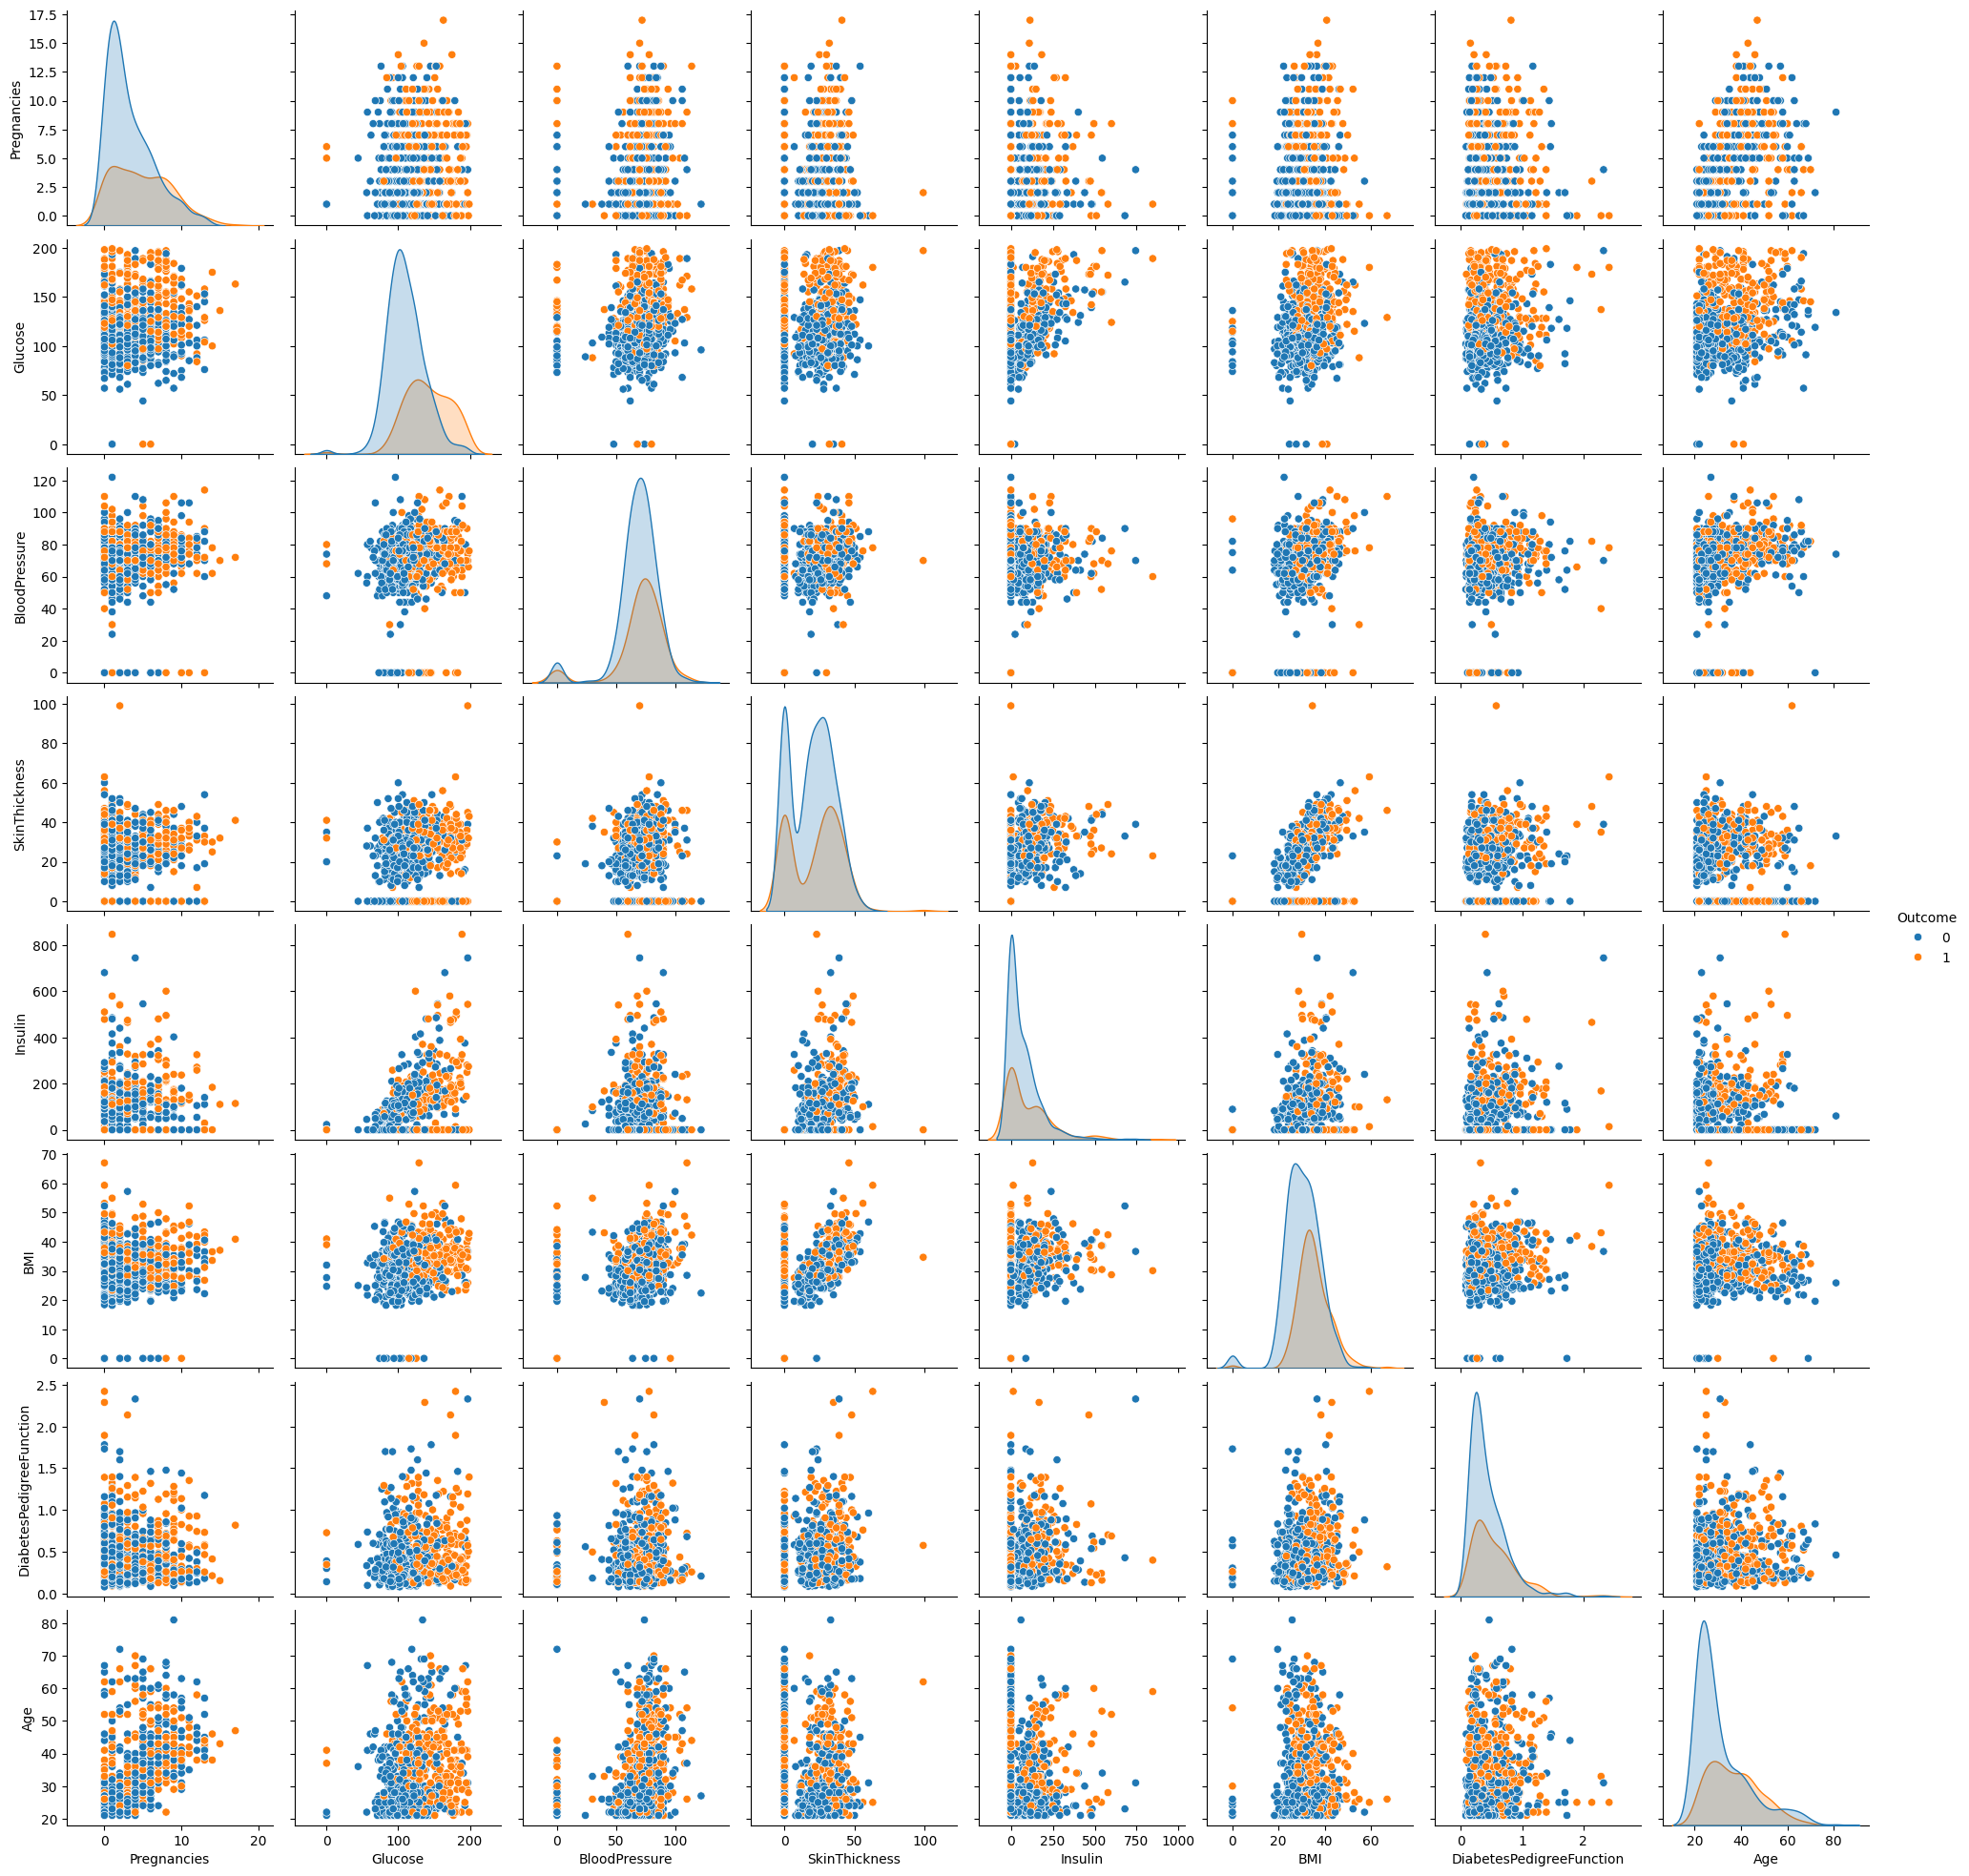

In [ ]:
p=sns.pairplot(df, hue = 'Outcome')

Através dos scatterplots é possível notar as relações entre os atributos. É possível também perceber que, de maneira geral, não existem atributos que separam bem essas classes, sendo o atributo glucose (glicose) o com o maior desempenho. Como não houveram atributos com grande poder de separação isso demonstra que o dataset se trata de um problema de classificação mais complexo.

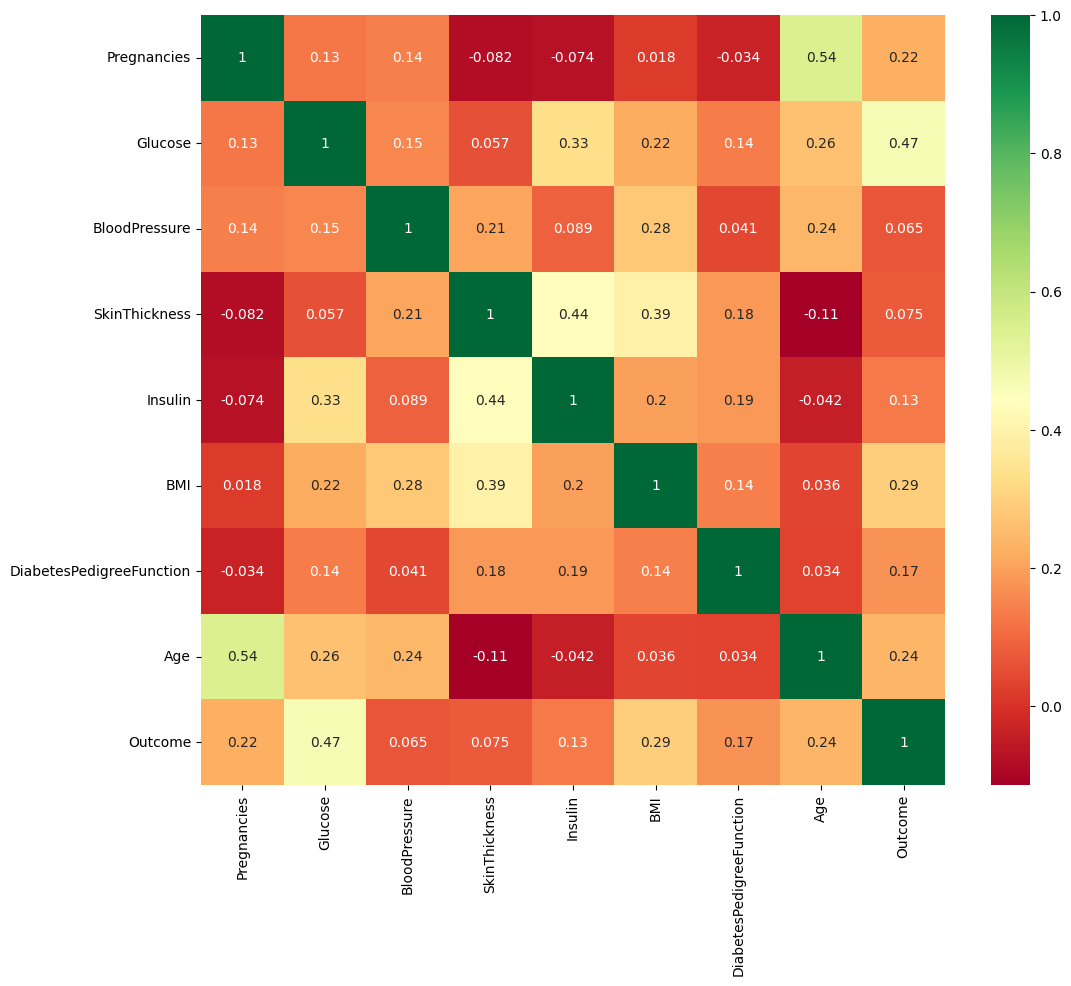

In [ ]:
plt.figure(figsize=(12,10))
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')

De forma complementar, podemos mostrar a relação entre os atributos através do *heatmap* da **matriz de correlação** acima. A matriz de correlação foi escolhida pois ela é menos afetada pela escala dos atributos. Nela, podemos observar que o atributo com maior correlação positiva com o atributo alvo *Outcome*, ou seja, com maior capacidade preditiva, foi justamente a variável *Glucose* que, nos scatterplots também conseguiu separar melhor as classes.
Entre as variáveis independentes não houve grandes destaques para correlação, mostrando a **ausência de atributos redundantes**. A ausência dessa colinearidade severa indica que não há necessidade imediata de PCA ou exclusão de atributos.

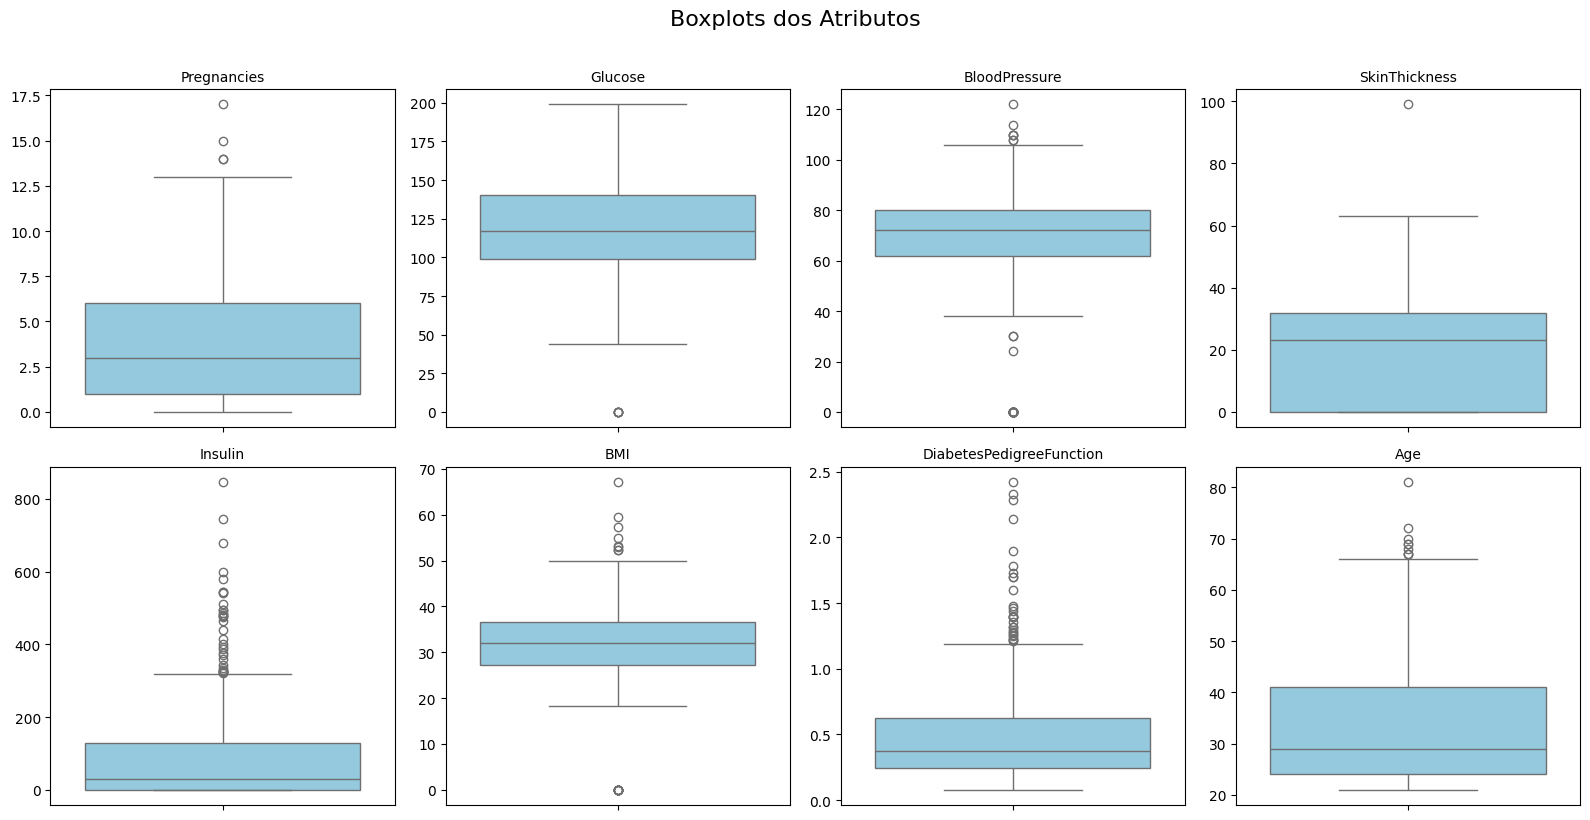

In [ ]:
target_col = 'Outcome'
features = df[[col for col in df.columns if col != target_col]]

n_cols = 4
n_rows = (len(features.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features.columns):
    sns.boxplot(
        y=df[feature],
        color='skyblue',
        ax=axes[i]
    )
    axes[i].set_title(f'{feature}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots dos Atributos', fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


Através dos boxplots é possível perceber a forte presença de outliers, inclusive com valores claramente inconsistentes como atributos como *Glucose* e *BMI* com *outliers* com valores em zero. <br/>

---
## **Pré-Processamento dos Dados**

## **Indentificando inconsistências**

Vimos que alguns atributos estavam com valores ruidosos, como por exemplo atributo como pressão sanguínea *BloodPressure* com valores 0, o que é incompatível com a vida. <br/>
Para resolver essa questão, a estratégia utilizada foi primeiro trocar esses valores inconsistentes por *nan*, para depois **imputar novos valores a partir da mediana**. Fazemos isso pois, se não trocarmos por *nan* antes de imputar, o valor da mediana vai ser fortemente afetado pelos 0's que estão incorretamente presentes no dataset.


In [ ]:
df_copy = df.copy(deep = True)

atributos = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_copy[atributos] = df_copy[atributos].replace(0,np.nan)

df_copy.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
df_copy.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## **Imputação por mediana**

In [ ]:
for col in colunas:
    df_copy[col].fillna(df_copy[col].median(), inplace=True)

/tmp/ipython-input-14-3786804040.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[col].fillna(df_copy[col].median(), inplace=True)


## **Winsorização**
Além da imputação por mediana, para remover valores muito extremos (outliers) do nosso dataset optamos por usar uma técnica de tratamento que não remova os dados extremos mas sim, limite seus valores a determinado percentil, neste caso 5%. <br/>
A decisão por esse método foi que, além dele reduzir o impacto de outliers extremos, ele também preserva a estrutura geral dos dados sem a perda dos dados

In [ ]:
for col in atributos:
    wins = winsorize(df_copy[col], limits=[0.05, 0.05])
    df_copy[col] = np.array(wins)
df_copy.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.638021,72.158854,28.927083,133.968750,32.332422,0.471876,33.240885,0.348958
std,3.369578,28.719099,10.443155,7.655040,56.190856,6.207864,0.331329,11.760232,0.476951
min,0.000000,80.000000,52.000000,14.000000,50.000000,22.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,181.000000,90.000000,44.000000,293.000000,44.500000,2.420000,81.000000,1.000000


In [ ]:
df_copy.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


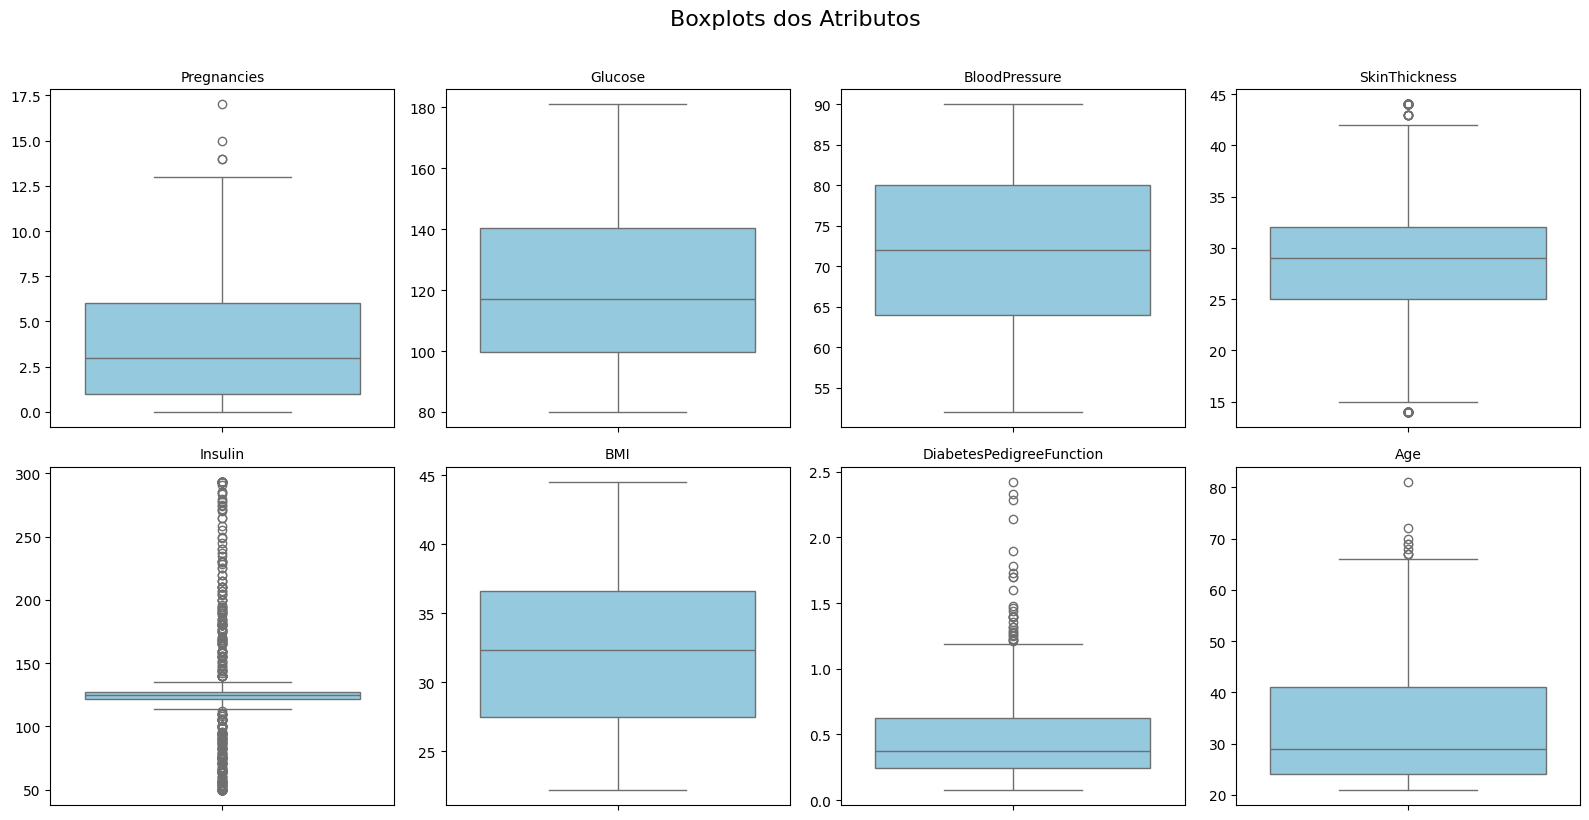

In [ ]:
target_col = 'Outcome'
features = df_copy[[col for col in df_copy.columns if col != target_col]]

n_cols = 4
n_rows = (len(features.columns) + n_cols-1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features.columns):
    sns.boxplot(
        y=df_copy[feature],
        color='skyblue',
        ax=axes[i]
    )
    axes[i].set_title(f'{feature}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots dos Atributos', fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


É possível perceber uma mudança significativa nos boxplots. </br>
A mudança que mais chamou nossa atenção foi a da insulina, em que houve uma grande quantidade de dados sendo representados como outliers, esse fato se deu principalmente por conta da imputação pela mediana. A proximadamente metade dos valores de insulina estavam zerados, ao trocá-los pela mediana, a distribuição se concentrou em um intervalo muito pequeno.

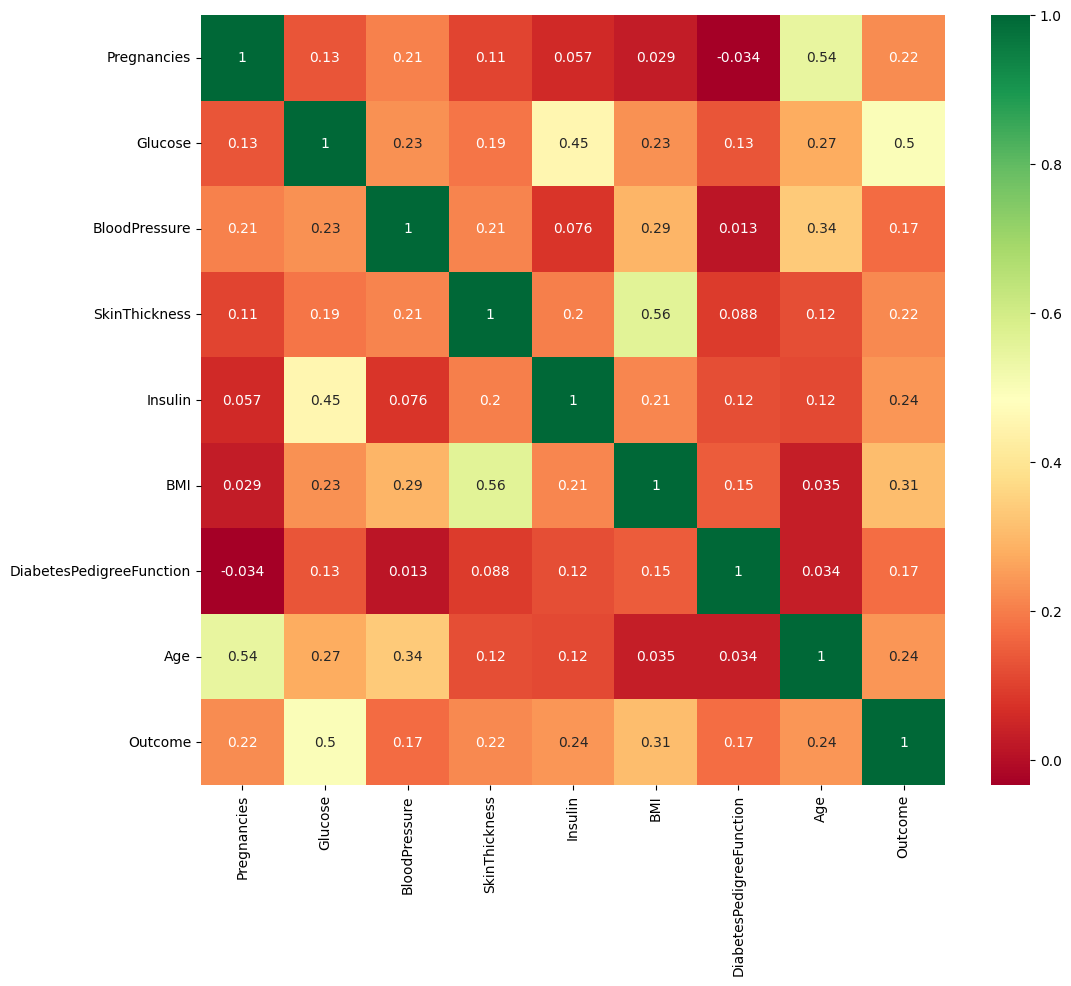

In [ ]:
plt.figure(figsize=(12,10))
p=sns.heatmap(df_copy.corr(), annot=True,cmap ='RdYlGn')

## **Normalização**

A normalização escolhida foi StandardScaler que funciona pegando cada valor de uma coluna e reescalando para ter média 0 e desvio padrão 1, usando a fórmula: $\frac{x - \bar{x}}{s}$ <br/>

Isso é importante porque, no dataset Pima Indians Diabetes, as variáveis têm escalas muito diferentes (por exemplo, idade pode ir até 80, enquanto a função de pedigree do diabetes varia pouco). Como redes neurais são sensíveis a essas diferenças de escala, normalizar com Min-Max ajuda o modelo a aprender melhor e mais rápido, evitando que atributos com valores maiores tenham mais influência do que outros.

In [ ]:
scaler = StandardScaler()

# features
X = df_copy.drop('Outcome', axis=1)
X = scaler.fit_transform(X)

# target
y = df_copy['Outcome']

---
## **Implementando o Modelo**

Esse modelo é uma rede neural simples do tipo MLP (Perceptron Multicamadas) com 2 camadas uma com 10 neurônios e outra com 1. <br>
A função de ativação usada nelas é a **ReLU**, que é rápida e ajuda o modelo a aprender relações não lineares entre as variáveis (como glicose, IMC, pressão etc.). <br/>
Na camada de saída optamos pela função de ativação **sigmoid**, que retorna um valor entre 0 e 1 o que é ideal para problemas de classificação binária como esse.  <br/>
Além disso o modelo foi treinado com a função de perda **binary_crossentropy**, que mede o erro para esse tipo de tarefa, e com o otimizador adam. <br/>
Também usamos **pesos de classe** para forçar o modelo a dar mais atenção à classe dos diabéticos, que é a minoria no conjunto de dados ao invés de fazer oversampling.

In [ ]:
def create_model(input_dim, class_weight=None):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
n_splits=5
epochs=100
batch_size=10

Optou-se por usar 100 épocas e batch size de 10 após a realização de alguns teste. As 100 épocas permitiram que o modelo tivesse tempo suficiente para aprender os padrões dos dados sem indícios claros de overfitting, já que os resultados nos folds da validação cruzada se estabilizaram em torno dessa quantidade. Já o batch size de 10 foi escolhido por ser pequeno o bastante para permitir atualizações frequentes dos pesos (ajudando na convergência), mas não tão pequeno a ponto de gerar instabilidade no gradiente. Essa configuração, embora simples, se mostrou eficaz para um problema de classificação binária com uma base de dados moderadamente pequena (768 amostras).

## **Amostragem**

O escolhido foi amostragem estratificada k-fold esse método de amostragem é importante especialmente nesse caso pois o dataset possui um leve desbalanceamento entre as classes: aproximadamente 65% de não diabéticos e 35% de diabéticos. <br/>
O **Stratified K-Fold** evita que o modelo treine ou seja avaliado com subconjuntos desbalanceados ao garantir que cada fold da validação cruzada mantenha essa mesma proporção de classes, o que poderia distorcer as métricas, especialmente o recall da classe minoritária (diabéticos). <br/>
Assim, optamos por uma amostragem estratificada em 5 folds que torna a avaliação mais aproximada do desempenho real do modelo.

In [ ]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)
accuracies = []
recalls = []
f1s = []
all_y_true = []
all_y_pred = []

## **Pesos**

A utilização de pesos serve para compensar o desbalanceamento das classes durante o treinamento do modelo. O método escolhido calcula pesos inversamente proporcionais à frequência de cada classe, fazendo com que seus **erros tenham mais impacto na função de perda** *loss function*

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    model = create_model(input_dim=X_train.shape[1])

    model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              verbose=0,
              class_weight=class_weight_dict)

    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Acurácia: {acc:.2f} | Recall (classe 1): {rec:.2f} | F1-score: {f1:.2f}")

    accuracies.append(acc)
    recalls.append(rec)
    f1s.append(f1)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)



--- Fold 1 ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Acurácia: 0.70 | Recall (classe 1): 0.70 | F1-score: 0.62

--- Fold 2 ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Acurácia: 0.74 | Recall (classe 1): 0.67 | F1-score: 0.64

--- Fold 3 ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Acurácia: 0.71 | Recall (classe 1): 0.65 | F1-score: 0.61

--- Fold 4 ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Acurácia: 0.78 | Recall (classe 1): 0.79 | F1-score: 0.71

--- Fold 5 ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Acurácia: 0.77 | Recall (classe 1): 0.74 | F1-score: 0.69


In [ ]:
print("\nResultados")
print(f"Acurácia média (k={n_splits}): {np.mean(accuracies):.2f} (+/- {np.std(accuracies):.2f})")
print(f"Recall médio (diabéticos): {np.mean(recalls):.2f}")
print(f"F1-score médio: {np.mean(f1s):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(all_y_true, all_y_pred, target_names=['Não Diabético', 'Diabético']))



Resultados
Acurácia média (k=5): 0.74 (+/- 0.03)
Recall médio (diabéticos): 0.71
F1-score médio: 0.66

Relatório de Classificação:
               precision    recall  f1-score   support

Não Diabético       0.83      0.76      0.79       500
    Diabético       0.61      0.71      0.66       268

     accuracy                           0.74       768
    macro avg       0.72      0.73      0.72       768
 weighted avg       0.75      0.74      0.74       768



No geral, o modelo está melhor em detectar diabéticos do que em evitá-los falsamente (recall>precision). Isso é positivo nesse tipo de contexto médicos, onde é um *falso negativo* pode ser pior do que um *falso positivo* que levaria a uma investigação posterior.

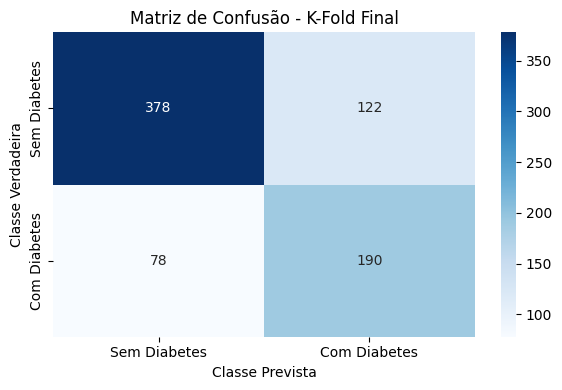

In [ ]:
confusion_mtx = confusion_matrix(all_y_true, all_y_pred)
labels = ['Sem Diabetes', 'Com Diabetes']

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - K-Fold Final')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.tight_layout()
plt.show()


A **matriz de confusão** mostra que o modelo teve um bom desempenho geral, com entre 75-80% de **acurácia**. Ele poderia ter tido apenas um melhor recall e precisão para classe minoritária (diabéticos) que é importante em contextos médicos, já que errar um caso positivo pode ter consequências piores. Apesar disso, houve uma boa quantidade de falsos negativos (diabéticos não detectados) e alguns falsos positivos, o que indica que ainda há espaço para ajustes.<br>
No geral, o modelo alcançou resultados razoáveis, o que é esperado para uma configuração mais simples de mlp em um problema mais complexo como esse de classificação.

## Otimização de Hiperparâmetros com Keras Tuner
Para melhorar o desempenho do nosso modelo de rede neural, vamos utilizar o **Keras Tuner**, uma ferramenta automática de busca de hiperparâmetros. O Keras Tuner permite encontrar, de forma eficiente, a melhor configuração da rede neural (como número de neurônios, funções de ativação, taxa de dropout, otimizador e taxa de aprendizado) para o nosso problema de classificação de diabetes. Com isso, conseguimos testar diversas arquiteturas e parâmetros de forma automatizada, economizando tempo e aumentando as chances de obter um modelo mais preciso e robusto.

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


Iniciando otimização com 30 trials e 5-fold cross-validation...
Dimensão de entrada: 8
Tamanho do dataset: 768 amostras
Reloading Tuner from keras_tuner_kfold/mlp_optimization_kfold/tuner0.json

MELHORES HYPERPARÂMETROS ENCONTRADOS
Neurônios na 1ª camada: 11
Ativação da 1ª camada: relu
Dropout na 1ª camada: False
Otimizador: adam
Learning rate: 0.001882

ARQUITETURA DA MELHOR REDE NEURAL
  1. Input Layer: 8 neurônios
  2. Hidden Layer 1: 11 neurônios (relu)
  3. Output Layer: 1 neurônio (sigmoid)

Otimizador: ADAM
Learning Rate: 0.001882
Parâmetros treináveis (aproximado): 111

AVALIAÇÃO FINAL COM MELHORES HYPERPARÂMETROS

--- Fold 1 ---
Acurácia: 0.7597 | Precisão: 0.6164 | Recall: 0.8333 | F1-score: 0.7087
Épocas treinadas: 12

--- Fold 2 ---
Acurácia: 0.7532 | Precisão: 0.6429 | Recall: 0.6667 | F1-score: 0.6545
Épocas treinadas: 19

--- Fold 3 ---
Acurácia: 0.7273 | Precisão: 0.5938 | Recall: 0.7037 | F1-score: 0.6441
Épocas treinadas: 19

--- Fold 4 ---
Acurácia: 0.7582 | Precisão

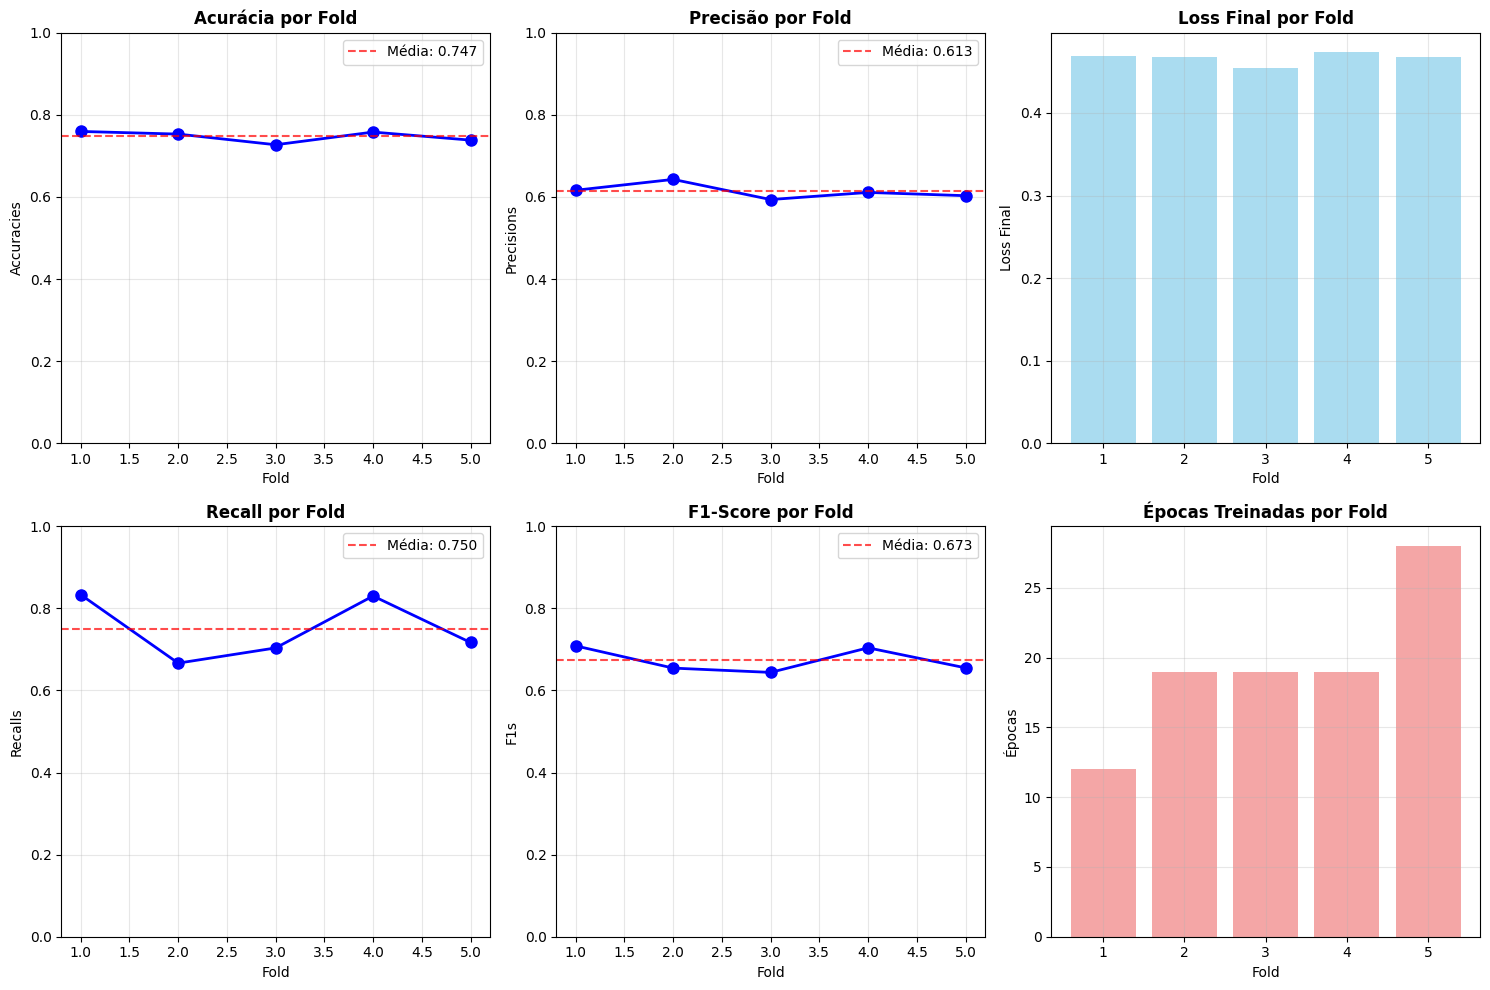

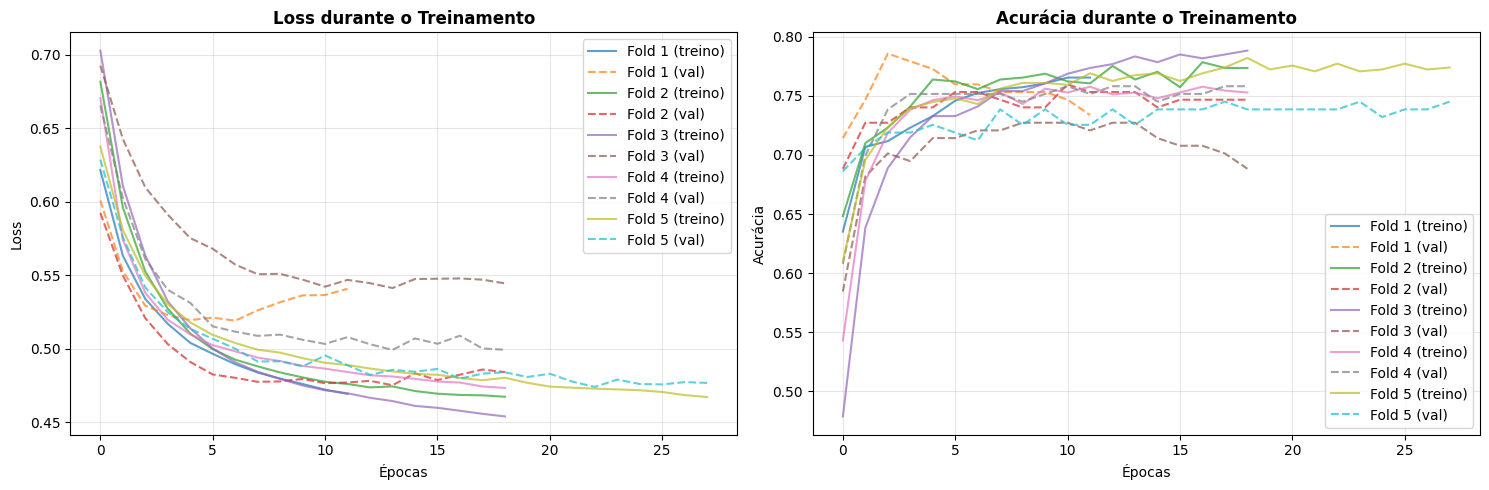

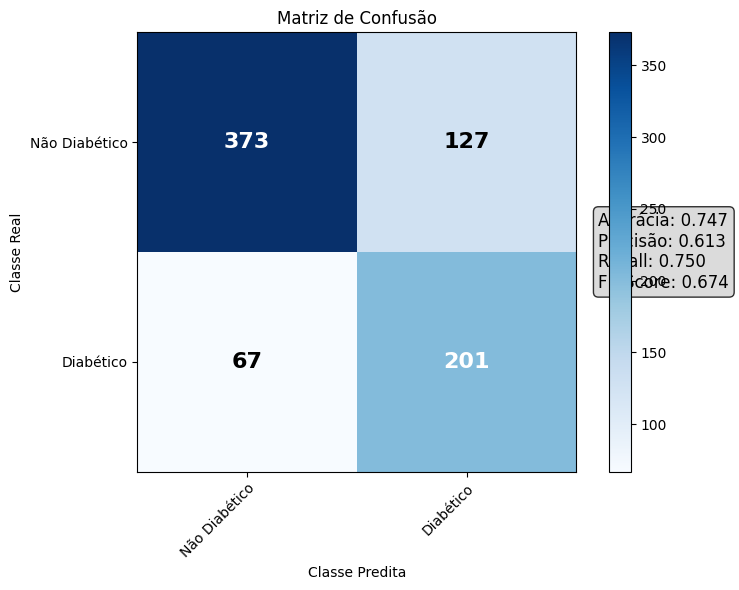


ESTATÍSTICAS DETALHADAS DA MATRIZ DE CONFUSÃO
Verdadeiros Negativos (TN):    373 (Não diabéticos corretamente classificados)
Falsos Positivos (FP):         127 (Não diabéticos classificados como diabéticos)
Falsos Negativos (FN):          67 (Diabéticos classificados como não diabéticos)
Verdadeiros Positivos (TP):    201 (Diabéticos corretamente classificados)

Total de predições corretas:    574 / 768
Total de predições incorretas:    194 / 768
Taxa de acerto: 74.7%
Taxa de erro: 25.3%


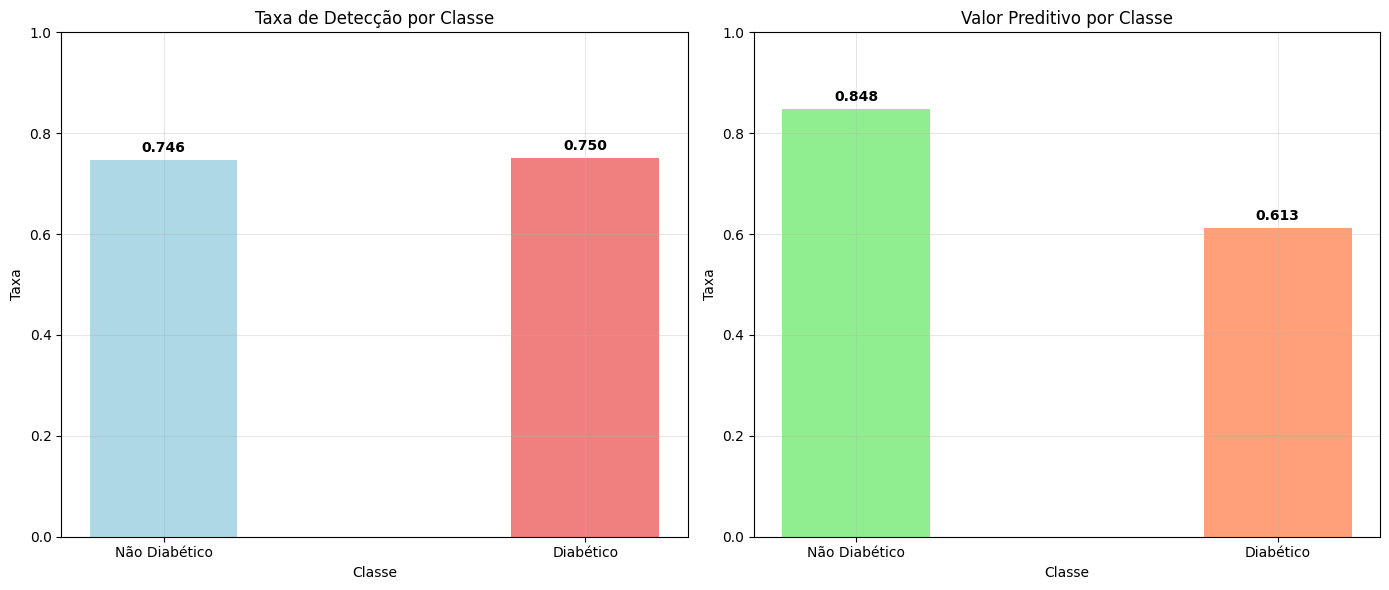


EXPLICAÇÃO DAS MÉTRICAS POR CLASSE
Para NÃO DIABÉTICOS:
  • Especificidade (Taxa de Verdadeiros Negativos): 0.746
    → De todos os não diabéticos, 74.6% foram corretamente identificados
  • Valor Preditivo Negativo: 0.848
    → Das predições 'não diabético', 84.8% estavam corretas

Para DIABÉTICOS:
  • Sensibilidade (Taxa de Verdadeiros Positivos): 0.750
    → De todos os diabéticos, 75.0% foram corretamente identificados
  • Valor Preditivo Positivo (Precisão): 0.613
    → Das predições 'diabético', 61.3% estavam corretas


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

def create_model_for_tuning(hp):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    model.add(Dense(
        units=hp.Int('units_1', min_value=2, max_value=20, step=1),
        activation=hp.Choice('activation_1', ['relu', 'tanh', 'sigmoid'])
    ))

    if hp.Boolean('dropout_1'):
        model.add(Dropout(rate=hp.Float('dropout_rate_1', 0.1, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

def create_model(input_dim, units_1=64, activation_1='relu',
                optimizer='adam', learning_rate=0.001, dropout_rate_1=0.0):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    model.add(Dense(units_1, activation=activation_1))

    if dropout_rate_1 > 0:
        model.add(Dropout(rate=dropout_rate_1))

    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

n_splits = 5
epochs = 100
batch_size = 10
max_trials = 30
patience = 5

input_dim = None

class CVTuner(kt.RandomSearch):
    def __init__(self, X, y, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.X = X
        self.y = y

    def run_trial(self, trial, *args, **kwargs):
        model = self.hypermodel.build(trial.hyperparameters)

        cv_scores = []
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)

        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]

            class_weights = compute_class_weight(
                class_weight='balanced',
                classes=np.unique(y_train),
                y=y_train
            )
            class_weight_dict = dict(enumerate(class_weights))

            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True
            )

            model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                class_weight=class_weight_dict,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping]
            )

            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            cv_scores.append(val_accuracy)

        return np.mean(cv_scores)

def optimize_hyperparameters_kfold(X, y):
    global input_dim
    input_dim = X.shape[1]

    print(f"Iniciando otimização com {max_trials} trials e {n_splits}-fold cross-validation...")
    print(f"Dimensão de entrada: {input_dim}")
    print(f"Tamanho do dataset: {X.shape[0]} amostras")

    tuner = CVTuner(
        X, y,
        create_model_for_tuning,
        objective='val_accuracy',
        max_trials=max_trials,
        directory='keras_tuner_kfold',
        project_name='mlp_optimization_kfold'
    )

    tuner.search()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\n{'='*60}")
    print("MELHORES HYPERPARÂMETROS ENCONTRADOS")
    print(f"{'='*60}")
    print(f"Neurônios na 1ª camada: {best_hps.get('units_1')}")
    print(f"Ativação da 1ª camada: {best_hps.get('activation_1')}")
    print(f"Dropout na 1ª camada: {best_hps.get('dropout_1')}")
    if best_hps.get('dropout_1'):
        print(f"Taxa de dropout na 1ª camada: {best_hps.get('dropout_rate_1')}")

    print(f"Otimizador: {best_hps.get('optimizer')}")
    print(f"Learning rate: {best_hps.get('learning_rate'):.6f}")

    return best_hps, tuner

def evaluate_best_model(X, y, best_hps):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)
    accuracies = []
    recalls = []
    f1s = []
    precisions = []
    all_y_true = []
    all_y_pred = []
    fold_histories = []

    print(f"\n{'='*60}")
    print("AVALIAÇÃO FINAL COM MELHORES HYPERPARÂMETROS")
    print(f"{'='*60}")

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n--- Fold {fold} ---")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        model_params = {
            'input_dim': X_train.shape[1],
            'units_1': best_hps.get('units_1'),
            'activation_1': best_hps.get('activation_1'),
            'optimizer': best_hps.get('optimizer'),
            'learning_rate': best_hps.get('learning_rate'),
            'dropout_rate_1': best_hps.get('dropout_rate_1', 0.0) if best_hps.get('dropout_1') else 0.0
        }

        model = create_model(**model_params)

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )

        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            class_weight=class_weight_dict,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping]
        )

        fold_histories.append(history)

        y_pred_prob = model.predict(X_test, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)

        print(f"Acurácia: {acc:.4f} | Precisão: {prec:.4f} | Recall: {rec:.4f} | F1-score: {f1:.4f}")
        print(f"Épocas treinadas: {len(history.history['loss'])}")

        accuracies.append(acc)
        recalls.append(rec)
        f1s.append(f1)
        precisions.append(prec)
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    print(f"\n{'='*60}")
    print("RESULTADOS FINAIS")
    print(f"{'='*60}")
    print(f"Acurácia média (k={n_splits}): {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
    print(f"Precisão média: {np.mean(precisions):.4f} (+/- {np.std(precisions):.4f})")
    print(f"Recall médio: {np.mean(recalls):.4f} (+/- {np.std(recalls):.4f})")
    print(f"F1-score médio: {np.mean(f1s):.4f} (+/- {np.std(f1s):.4f})")

    print(f"\n{'='*60}")
    print("RELATÓRIO DE CLASSIFICAÇÃO FINAL")
    print(f"{'='*60}")
    print(classification_report(all_y_true, all_y_pred, target_names=['Não Diabético', 'Diabético']))

    print(f"\n{'='*60}")
    print("MATRIZ DE CONFUSÃO")
    print(f"{'='*60}")
    cm = confusion_matrix(all_y_true, all_y_pred)
    print(f"                 Predição")
    print(f"                 Não Diabético  Diabético")
    print(f"Real Não Diabético      {cm[0,0]:>6d}        {cm[0,1]:>6d}")
    print(f"Real Diabético          {cm[1,0]:>6d}        {cm[1,1]:>6d}")

    tn, fp, fn, tp = cm.ravel()
    print(f"\nEstatísticas da Matriz de Confusão:")
    print(f"Verdadeiros Negativos (TN): {tn:>6d} | Falsos Positivos (FP): {fp:>6d}")
    print(f"Falsos Negativos (FN):      {fn:>6d} | Verdadeiros Positivos (TP): {tp:>6d}")
    print(f"Total de predições corretas: {tn + tp:>6d} / {len(all_y_true)} ({((tn + tp) / len(all_y_true) * 100):.1f}%)")

    return {
        'accuracies': accuracies,
        'precisions': precisions,
        'recalls': recalls,
        'f1s': f1s,
        'all_y_true': all_y_true,
        'all_y_pred': all_y_pred,
        'fold_histories': fold_histories,
        'confusion_matrix': cm
    }

def plot_results(results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    metrics = ['accuracies', 'precisions', 'recalls', 'f1s']
    titles = ['Acurácia por Fold', 'Precisão por Fold', 'Recall por Fold', 'F1-Score por Fold']

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        row, col = i // 2, i % 2
        axes[row, col].plot(range(1, n_splits + 1), results[metric], 'bo-', linewidth=2, markersize=8)
        axes[row, col].set_title(title, fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel('Fold')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_ylim(0, 1)

        mean_val = np.mean(results[metric])
        axes[row, col].axhline(y=mean_val, color='r', linestyle='--', alpha=0.7,
                              label=f'Média: {mean_val:.3f}')
        axes[row, col].legend()

    axes[0, 2].set_title('Loss Final por Fold', fontsize=12, fontweight='bold')
    final_losses = [hist.history['loss'][-1] for hist in results['fold_histories']]
    axes[0, 2].bar(range(1, n_splits + 1), final_losses, color='skyblue', alpha=0.7)
    axes[0, 2].set_xlabel('Fold')
    axes[0, 2].set_ylabel('Loss Final')
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 2].set_title('Épocas Treinadas por Fold', fontsize=12, fontweight='bold')
    epochs_trained = [len(hist.history['loss']) for hist in results['fold_histories']]
    axes[1, 2].bar(range(1, n_splits + 1), epochs_trained, color='lightcoral', alpha=0.7)
    axes[1, 2].set_xlabel('Fold')
    axes[1, 2].set_ylabel('Épocas')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(results):
    cm = results['confusion_matrix']

    fig, ax = plt.subplots(figsize=(8, 6))

    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    classes = ['Não Diabético', 'Diabético']
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title='Matriz de Confusão',
           ylabel='Classe Real',
           xlabel='Classe Predita')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]:d}',
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=16, fontweight='bold')

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    stats_text = f'Acurácia: {accuracy:.3f}\nPrecisão: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
    ax.text(1.05, 0.5, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*50}")
    print("ESTATÍSTICAS DETALHADAS DA MATRIZ DE CONFUSÃO")
    print(f"{'='*50}")
    print(f"Verdadeiros Negativos (TN): {tn:>6d} (Não diabéticos corretamente classificados)")
    print(f"Falsos Positivos (FP):      {fp:>6d} (Não diabéticos classificados como diabéticos)")
    print(f"Falsos Negativos (FN):      {fn:>6d} (Diabéticos classificados como não diabéticos)")
    print(f"Verdadeiros Positivos (TP): {tp:>6d} (Diabéticos corretamente classificados)")
    print(f"\nTotal de predições corretas: {tn + tp:>6d} / {len(results['all_y_true'])}")
    print(f"Total de predições incorretas: {fp + fn:>6d} / {len(results['all_y_true'])}")
    print(f"Taxa de acerto: {accuracy:.1%}")
    print(f"Taxa de erro: {1-accuracy:.1%}")

def plot_class_metrics(results):
    y_true = results['all_y_true']
    y_pred = results['all_y_pred']

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

    classes = ['Não Diabético', 'Diabético']
    sensitivity_specificity = [specificity, sensitivity]
    ppv_npv = [npv, ppv]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    x = np.arange(len(classes))
    width = 0.35

    ax1.bar(x, sensitivity_specificity, width, label='Taxa de Detecção', color=['lightblue', 'lightcoral'])
    ax1.set_xlabel('Classe')
    ax1.set_ylabel('Taxa')
    ax1.set_title('Taxa de Detecção por Classe')
    ax1.set_xticks(x)
    ax1.set_xticklabels(classes)
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)

    for i, v in enumerate(sensitivity_specificity):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

    ax2.bar(x, ppv_npv, width, label='Valor Preditivo', color=['lightgreen', 'lightsalmon'])
    ax2.set_xlabel('Classe')
    ax2.set_ylabel('Taxa')
    ax2.set_title('Valor Preditivo por Classe')
    ax2.set_xticks(x)
    ax2.set_xticklabels(classes)
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)

    for i, v in enumerate(ppv_npv):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("EXPLICAÇÃO DAS MÉTRICAS POR CLASSE")
    print(f"{'='*60}")
    print("Para NÃO DIABÉTICOS:")
    print(f"  • Especificidade (Taxa de Verdadeiros Negativos): {specificity:.3f}")
    print(f"    → De todos os não diabéticos, {specificity:.1%} foram corretamente identificados")
    print(f"  • Valor Preditivo Negativo: {npv:.3f}")
    print(f"    → Das predições 'não diabético', {npv:.1%} estavam corretas")

    print(f"\nPara DIABÉTICOS:")
    print(f"  • Sensibilidade (Taxa de Verdadeiros Positivos): {sensitivity:.3f}")
    print(f"    → De todos os diabéticos, {sensitivity:.1%} foram corretamente identificados")
    print(f"  • Valor Preditivo Positivo (Precisão): {ppv:.3f}")
    print(f"    → Das predições 'diabético', {ppv:.1%} estavam corretas")

def plot_training_history(results):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss durante o Treinamento', fontsize=12, fontweight='bold')
    for i, hist in enumerate(results['fold_histories']):
        axes[0].plot(hist.history['loss'], label=f'Fold {i+1} (treino)', alpha=0.7)
        axes[0].plot(hist.history['val_loss'], label=f'Fold {i+1} (val)', alpha=0.7, linestyle='--')
    axes[0].set_xlabel('Épocas')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_title('Acurácia durante o Treinamento', fontsize=12, fontweight='bold')
    for i, hist in enumerate(results['fold_histories']):
        axes[1].plot(hist.history['accuracy'], label=f'Fold {i+1} (treino)', alpha=0.7)
        axes[1].plot(hist.history['val_accuracy'], label=f'Fold {i+1} (val)', alpha=0.7, linestyle='--')
    axes[1].set_xlabel('Épocas')
    axes[1].set_ylabel('Acurácia')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_best_architecture(best_hps):
    print(f"\n{'='*60}")
    print("ARQUITETURA DA MELHOR REDE NEURAL")
    print(f"{'='*60}")

    layers = []
    layers.append(f"Input Layer: {input_dim} neurônios")

    layer1_info = f"Hidden Layer 1: {best_hps.get('units_1')} neurônios ({best_hps.get('activation_1')})"
    if best_hps.get('dropout_1'):
        layer1_info += f" + Dropout ({best_hps.get('dropout_rate_1'):.1f})"
    layers.append(layer1_info)

    layers.append("Output Layer: 1 neurônio (sigmoid)")

    for i, layer in enumerate(layers):
        print(f"  {i+1}. {layer}")

    print(f"\nOtimizador: {best_hps.get('optimizer').upper()}")
    print(f"Learning Rate: {best_hps.get('learning_rate'):.6f}")

    total_params = input_dim * best_hps.get('units_1') + best_hps.get('units_1')
    total_params += best_hps.get('units_1') * 1 + 1

    print(f"Parâmetros treináveis (aproximado): {total_params:,}")

best_hps, tuner = optimize_hyperparameters_kfold(X, y)

visualize_best_architecture(best_hps)

results = evaluate_best_model(X, y, best_hps)

plot_results(results)
plot_training_history(results)
plot_confusion_matrix(results)
plot_class_metrics(results)